Data Loaded. Total Samples: 2036

--- Descriptive Statistics ---
Feature      | Mean       | Std Dev   
----------------------------------------
AAPL_Close   | 137.06     | 67.82     
AAPL_Open    | 136.93     | 67.75     
AAPL_Vol     | 93941877.70 | 54325424.89
MSFT_Close   | 266.52     | 126.90    
MSFT_Vol     | 27824474.12 | 12388381.79
TSLA_Close   | 185.88     | 128.59    
TSLA_Vol     | 123278664.39 | 75929935.33

--- Outlier Detection ---
AAPL_Close  : 0 outliers detected.
AAPL_Open   : 0 outliers detected.
AAPL_Vol    : 86 outliers detected.
MSFT_Close  : 0 outliers detected.
MSFT_Vol    : 115 outliers detected.
TSLA_Close  : 0 outliers detected.
TSLA_Vol    : 154 outliers detected.


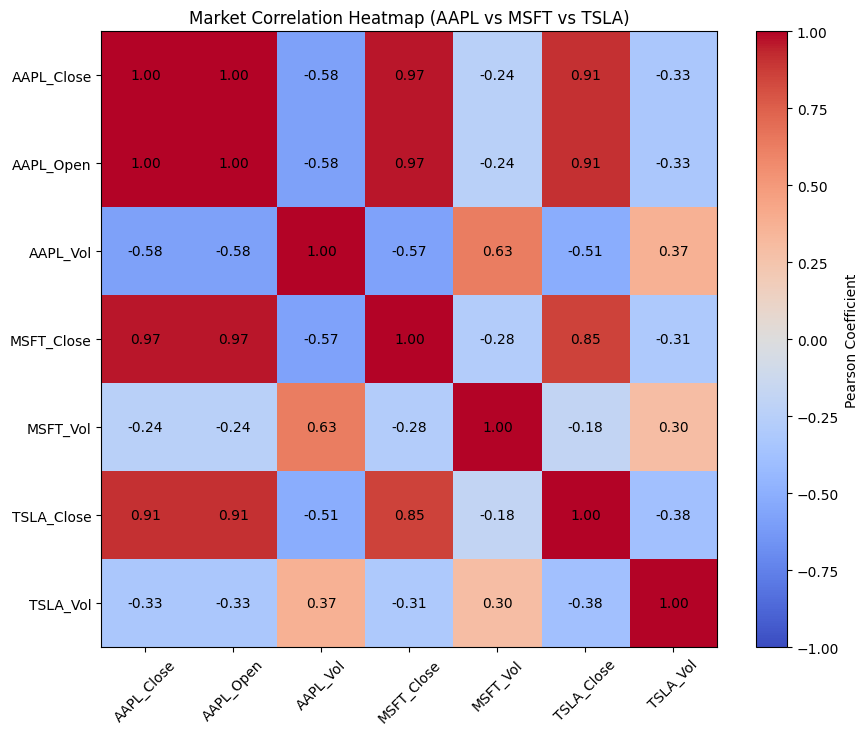

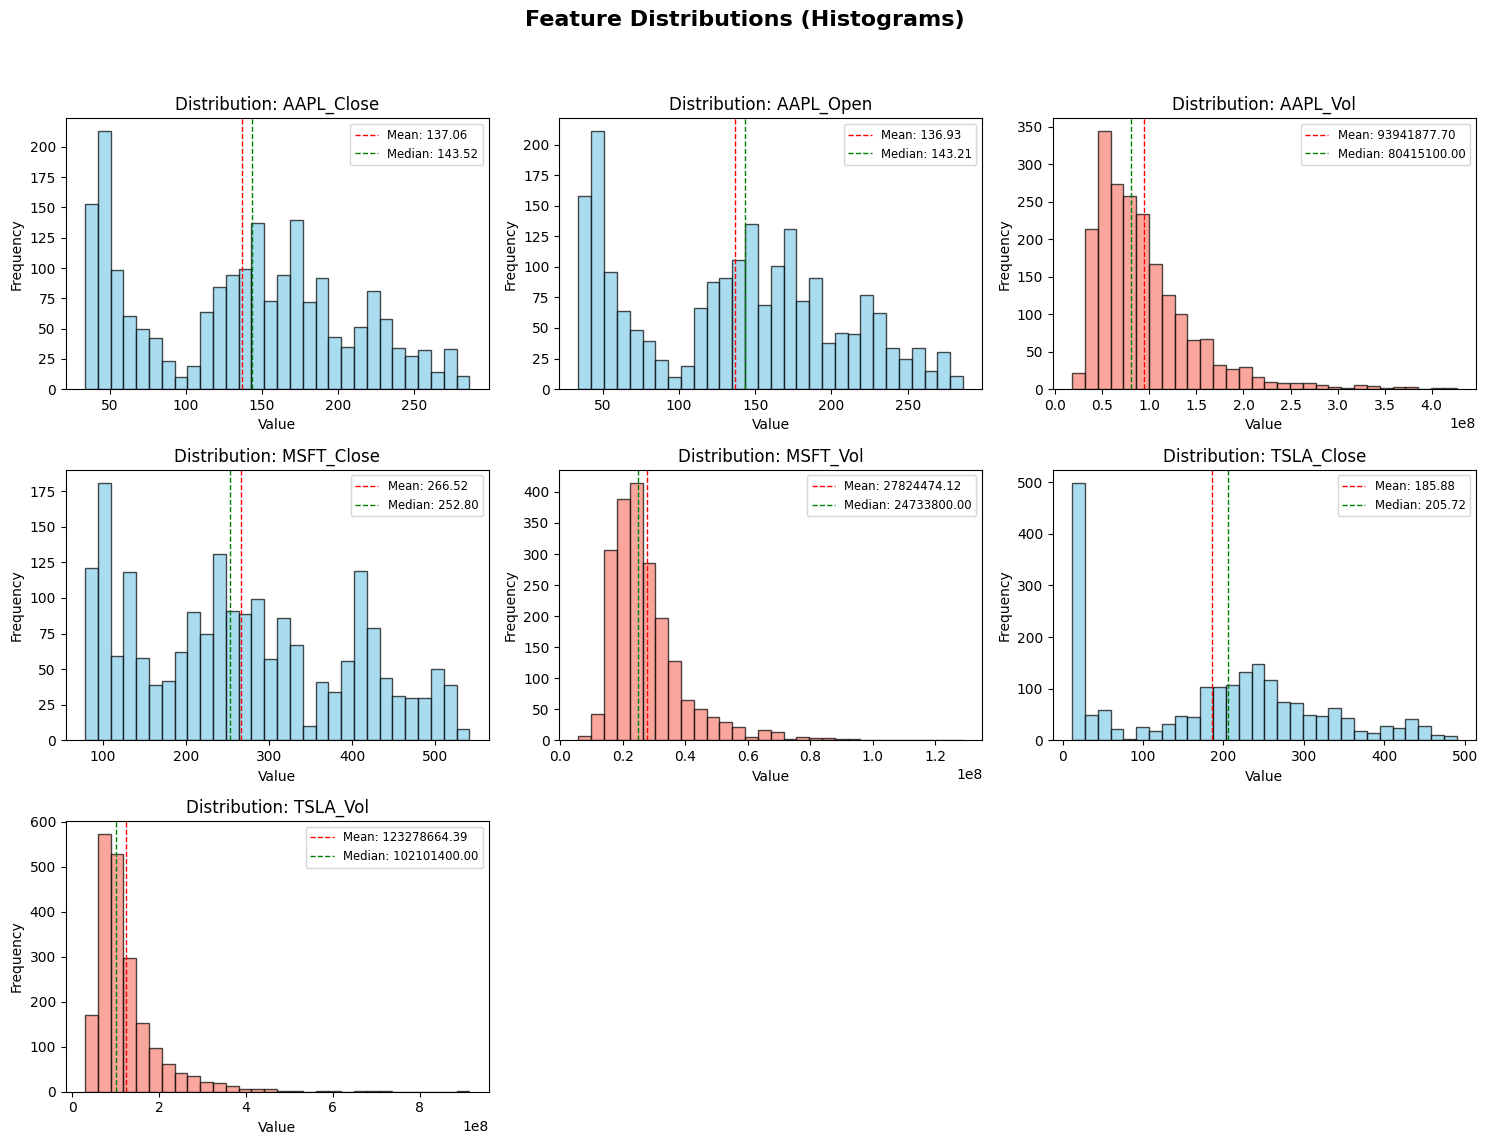


 EDA Part A Completed 


In [9]:
# part A

# PART A: Exploratory Data Analysis (EDA) & Data Preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DATA LOADING & CLEANING

df_raw = pd.read_csv('stock_market_data.csv', header=[0,1])

# Target: Apple Close Price
# Features: Apple Open/Vol, Microsoft Close/Vol, Tesla Close/Vol
data = pd.DataFrame()
data['AAPL_Close'] = df_raw['Close']['AAPL']
data['AAPL_Open']  = df_raw['Open']['AAPL']
data['AAPL_Vol']   = df_raw['Volume']['AAPL']
data['MSFT_Close'] = df_raw['Close']['MSFT']
data['MSFT_Vol']   = df_raw['Volume']['MSFT']
data['TSLA_Close'] = df_raw['Close']['TSLA']
data['TSLA_Vol']   = df_raw['Volume']['TSLA']

# Remove rows with missing values (NaN) to ensure mathematical stability
data = data.dropna()
print(f"Data Loaded. Total Samples: {len(data)}")

# STATISTICAL ANALYSIS (FROM SCRATCH)

# Std Dev = sqrt( Σ(x - μ)² / N )

def get_stats(values):
    n = len(values)
    mean = sum(values) / n
    variance = sum((x - mean)**2 for x in values) / n
    return mean, variance ** 0.5

print("\n--- Descriptive Statistics ---")
print(f"{'Feature':<12} | {'Mean':<10} | {'Std Dev':<10}")
print("-" * 40)
for col in data.columns:
    mu, sigma = get_stats(data[col].values)
    print(f"{col:<12} | {mu:<10.2f} | {sigma:<10.2f}")

# OUTLIER DETECTION (IQR METHOD)
# Logic: Data points outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR] are outliers.
print("\n--- Outlier Detection ---")
for col in data.columns:
    sorted_vals = sorted(data[col].values)
    n = len(sorted_vals)
    q1, q3 = sorted_vals[int(0.25*n)], sorted_vals[int(0.75*n)]
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outliers = sum(1 for x in sorted_vals if x < lower or x > upper)
    print(f"{col:<12}: {outliers} outliers detected.")

# CORRELATION MATRIX (MATH IMPLEMENTATION)
# Formula: Pearson Correlation (r)
# r = Covariance(X, Y) / (StdDev(X) * StdDev(Y))

def get_correlation(x, y):
    mu_x, sigma_x = get_stats(x)
    mu_y, sigma_y = get_stats(y)
    covariance = sum((x[i] - mu_x) * (y[i] - mu_y) for i in range(len(x))) / len(x)
    return covariance / (sigma_x * sigma_y)

# Compute 7x7 Matrix
cols = data.columns
matrix = np.zeros((len(cols), len(cols)))
for i in range(len(cols)):
    for j in range(len(cols)):
        matrix[i, j] = get_correlation(data[cols[i]].values, data[cols[j]].values)

# Visualization
plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Coefficient')
plt.xticks(range(len(cols)), cols, rotation=45)
plt.yticks(range(len(cols)), cols)
plt.title("Market Correlation Heatmap (AAPL vs MSFT vs TSLA)")
for i in range(len(cols)):
    for j in range(len(cols)):
        plt.text(j, i, f"{matrix[i, j]:.2f}", ha='center', va='center', color='black')
plt.show()


# 5. FEATURE DISTRIBUTION (HISTOGRAMS)

# Logic: We plot the frequency distribution of each feature. 
# This helps identify if the data is skewed or follows a normal distribution.

plt.figure(figsize=(15, 12))
plt.suptitle("Feature Distributions (Histograms)", fontsize=16, fontweight='bold')

for i, col in enumerate(data.columns):
    plt.subplot(3, 3, i + 1)
    # Using 'skyblue' for price data and 'salmon' for volume data to distinguish
    color = 'salmon' if 'Vol' in col else 'skyblue'
    
    plt.hist(data[col], bins=30, color=color, edgecolor='black', alpha=0.7)
    
    # Calculate mean and median to show skewness
    col_mean = np.mean(data[col])
    col_median = np.median(data[col])
    
    plt.axvline(col_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {col_mean:.2f}')
    plt.axvline(col_median, color='green', linestyle='dashed', linewidth=1, label=f'Median: {col_median:.2f}')
    
    plt.title(f"Distribution: {col}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend(fontsize='small')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n EDA Part A Completed ")

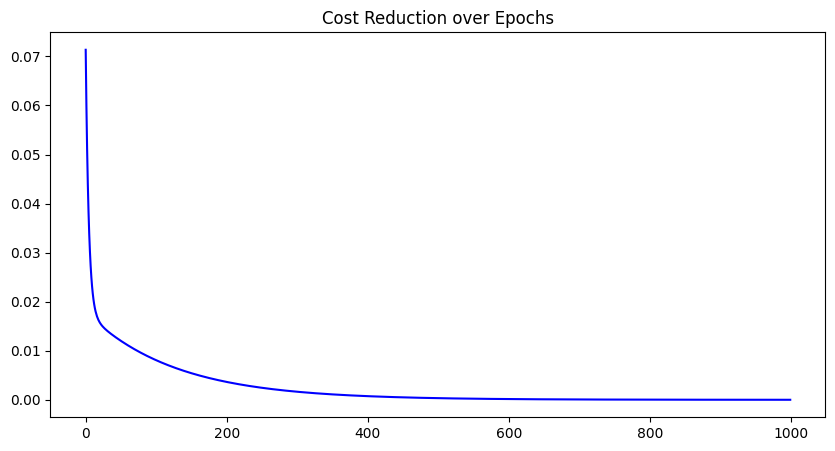

--- PART B OUTPUT ---
R-Squared: 0.971603
RMSE (Dollars): 3.8948


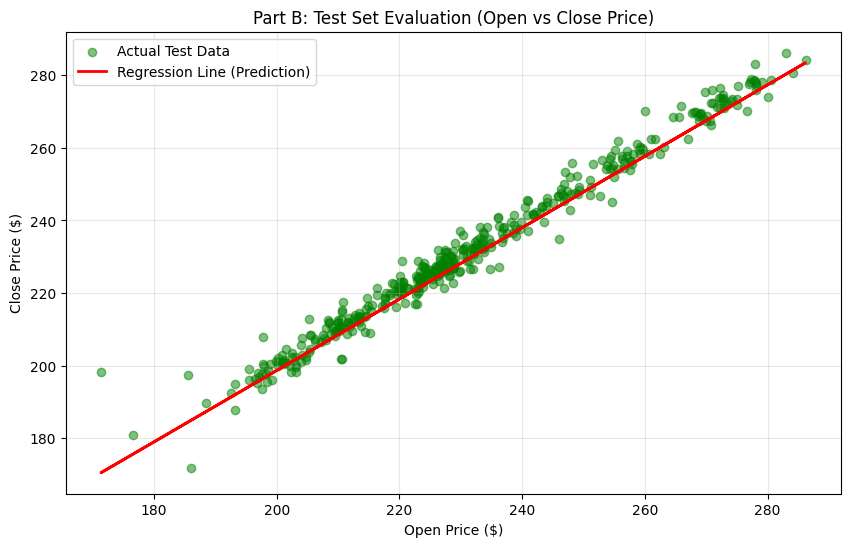

Visualized 408 test samples.


In [10]:
# PART B - SIMPLE LINEAR REGRESSION (GRADIENT DESCENT)

import pandas as pd
import matplotlib.pyplot as plt

# 1. LOAD DATA & NORMALIZE
df_raw = pd.read_csv('stock_market_data.csv', header=[0,1])
data = pd.DataFrame()
data['x'] = df_raw['Open']['AAPL']
data['y'] = df_raw['Close']['AAPL']
data = data.dropna()

x_min, x_max = data['x'].min(), data['x'].max()
y_min, y_max = data['y'].min(), data['y'].max()

X_norm = (data['x'].values - x_min) / (x_max - x_min)
y_norm = (data['y'].values - y_min) / (y_max - y_min)

# 2. TRAIN-TEST SPLIT (80% - 20%)
split = int(len(X_norm) * 0.8)
X_train, X_test = X_norm[:split], X_norm[split:]
y_train, y_test = y_norm[:split], y_norm[split:]

# 3. GRADIENT DESCENT ALGORITHM
m, c = 0.0, 0.0
alpha, epochs = 0.1, 1000
n = len(X_train)
cost_history = []

for i in range(epochs):
    y_pred = m * X_train + c
    error = y_pred - y_train
    cost = (1/(2*n)) * np.sum(error**2)
    cost_history.append(cost)
    dm = (1/n) * np.sum(error * X_train)
    dc = (1/n) * np.sum(error)
    m, c = m - alpha * dm, c - alpha * dc

# 4. VISUALIZATION
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), cost_history, color='blue')
plt.title('Cost Reduction over Epochs')
plt.show()

# 5. INVERSE TRANSFORM FOR EVALUATION
y_pred_scaled = m * X_test + c
X_test_real = X_test * (x_max - x_min) + x_min
y_test_real = y_test * (y_max - y_min) + y_min
y_pred_real = y_pred_scaled * (y_max - y_min) + y_min

# PART B EVALUATION (DOLLAR CONVERSION)
# Predict on Test Set (Scaled)
y_pred_scaled = m * X_test + c

# Inverse Transform (Convert 0-1 back to Dollars)
y_test_dollars = y_test * (y_max - y_min) + y_min
y_pred_dollars = y_pred_scaled * (y_max - y_min) + y_min

# Metrics Calculation
mse_b = np.mean((y_test_dollars - y_pred_dollars)**2)
rmse_b = np.sqrt(mse_b)

# R-Squared
ss_res = np.sum((y_test_dollars - y_pred_dollars)**2)
ss_tot = np.sum((y_test_dollars - np.mean(y_test_dollars))**2)
r2_b = 1 - (ss_res / ss_tot)

print(f"--- PART B OUTPUT ---")
print(f"R-Squared: {r2_b:.6f}")
print(f"RMSE (Dollars): {rmse_b:.4f}")


# VISUALIZATION: TEST SET RESULTS (ORIGINAL SCALE)


# 1. Predict on the Test Set (in scaled units)
y_pred_scaled = m * X_test + c

# 2. Inverse Transform: Convert back from [0,1] to actual Dollars
# Formula: Original = (Scaled * Range) + Min
X_test_dollars = X_test * (x_max - x_min) + x_min
y_test_dollars = y_test * (y_max - y_min) + y_min
y_pred_dollars = y_pred_scaled * (y_max - y_min) + y_min

# 3. Create the Plot
plt.figure(figsize=(10, 6))

# Plot the actual test data points
plt.scatter(X_test_dollars, y_test_dollars, color='green', alpha=0.5, label='Actual Test Data')

# Plot the regression line
# Note: We use the same X values but plot against our predictions
plt.plot(X_test_dollars, y_pred_dollars, color='red', linewidth=2, label='Regression Line (Prediction)')

plt.title('Part B: Test Set Evaluation (Open vs Close Price)')
plt.xlabel('Open Price ($)')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Visualized {len(X_test)} test samples.")

Data Loaded Successfully. Rows: 2036
Sample of Data (First 5 rows):
           y       Open          Vol       MSFT       TSLA
1  40.341885  39.850084  102223600.0  79.050354  21.368668
2  40.334866  40.405124  118071600.0  79.418282  21.150000
3  40.522221  40.407465   89738400.0  80.117271  20.974667
4  40.983578  40.618239   94640000.0  81.110565  21.105333
5  40.831341  40.831341   82271200.0  81.193336  22.427334

Training Data Shape: (1628, 5)

--- Learned Coefficients (Standardized) ---
Intercept   : -0.000203
Open        : 0.970905
Volume      : -0.001030
MSFT        : 0.021150
TSLA        : 0.008126

 Model Performance Metrics (Test Set) 
Intercept (θ₀):   -0.000203
MSE:              10.9066
RMSE:             3.3025 (Avg. error in Dollars)
R-Squared:        0.97958

 Coefficient Interpretation 
Feature 'Intercept' has a negative impact on Apple's Close price.
Feature 'Open' has a positive impact on Apple's Close price.
Feature 'Volume' has a negative impact on Apple's Close pr

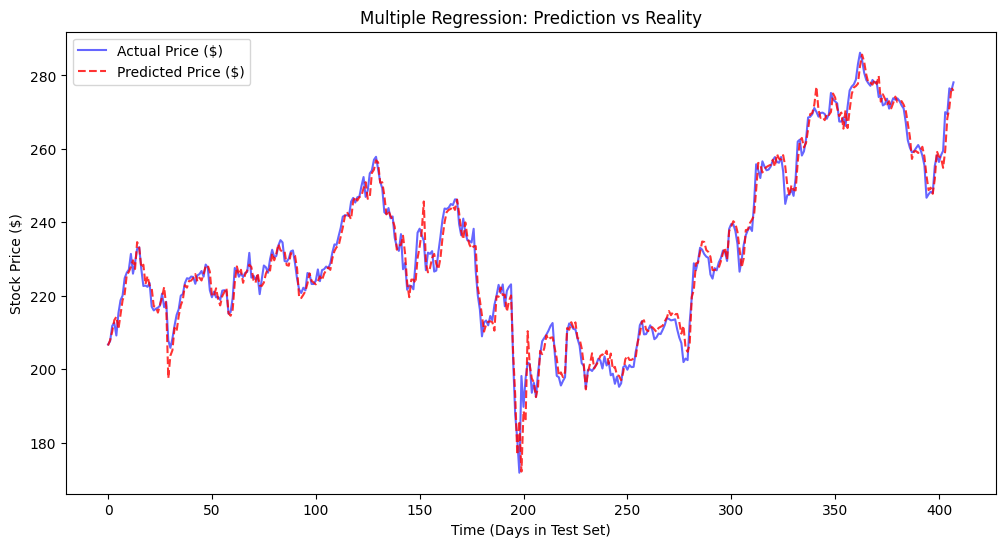

In [11]:
# PART C: MULTIPLE LINEAR REGRESSION (ROBUST VERSION)

# Goal: Predict Apple Price using Market Context.
# FIX: Force float conversion and use Z-Score Standardization to prevent errors.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  LOAD DATA & FORCE NUMBERS

df_raw = pd.read_csv('stock_market_data.csv', header=[0,1])
data = pd.DataFrame()

# We force .astype(float) to ensure no strings/text ruin the math
data['y']    = pd.to_numeric(df_raw['Close']['AAPL'], errors='coerce')
data['Open'] = pd.to_numeric(df_raw['Open']['AAPL'], errors='coerce')
data['Vol']  = pd.to_numeric(df_raw['Volume']['AAPL'], errors='coerce')
data['MSFT'] = pd.to_numeric(df_raw['Close']['MSFT'], errors='coerce')
data['TSLA'] = pd.to_numeric(df_raw['Close']['TSLA'], errors='coerce')

# IMPORTANT: Drop any rows that failed to convert (NaNs)
data = data.dropna()

print(f"Data Loaded Successfully. Rows: {len(data)}")
print("Sample of Data (First 5 rows):")
print(data.head())

#  STANDARDIZATION (Z-SCORE SCALING)

# To make the matrix math stable, we scale data: (X - Mean) / Std Dev
# This makes all values centered around 0 with a range approx -3 to +3.

def standardize(column):
    return (column - column.mean()) / column.std()

# Store mean/std to un-scale later for plotting
y_mean = data['y'].mean()
y_std  = data['y'].std()

# Scale Features
data['Open'] = standardize(data['Open'])
data['Vol']  = standardize(data['Vol'])
data['MSFT'] = standardize(data['MSFT'])
data['TSLA'] = standardize(data['TSLA'])
# Scale Target
data['y_scaled'] = standardize(data['y'])

# Add Bias (Intercept) AFTER scaling. It must be 1.0.
data['Bias'] = 1.0

# 3. MATRIX SETUP

X = data[['Bias', 'Open', 'Vol', 'MSFT', 'TSLA']].values
y = data['y_scaled'].values

# Split 80/20
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\nTraining Data Shape: {X_train.shape}")

# 4. TRAINING (NORMAL EQUATION)

# Formula: theta = (X^T * X)^(-1) * X^T * y
# We use pseudo-inverse (pinv) for safety.

def train_normal_equation(X, y):
    X_T = X.T
    XTX = X_T.dot(X)
    XTX_inv = np.linalg.pinv(XTX)
    theta = XTX_inv.dot(X_T).dot(y)
    return theta

theta = train_normal_equation(X_train, y_train)

print("\n--- Learned Coefficients (Standardized) ---")
features = ['Intercept', 'Open', 'Volume', 'MSFT', 'TSLA']
for i, name in enumerate(features):
    print(f"{name:<12}: {theta[i]:.6f}")


# 5. DETAILED EVALUATION (MSE, RMSE, R²)

# We evaluate on the Test Set (20%) using real dollar values for better interpretation.

# A. Generate Predictions
y_pred_scaled = X_test.dot(theta)

# B. Inverse Transform (Convert back to Dollars)
y_test_dollars = (y_test * y_std) + y_mean
y_pred_dollars = (y_pred_scaled * y_std) + y_mean

# C. Calculate Metrics Manually (Math from Scratch)
n_test = len(y_test_dollars)

# Mean Squared Error (MSE): Average of squared errors
mse = np.sum((y_test_dollars - y_pred_dollars)**2) / n_test

# Root Mean Squared Error (RMSE): Square root of MSE (In Dollar units)
rmse = np.sqrt(mse)

# R-Squared (R²): Proportion of variance explained
ss_res = np.sum((y_test_dollars - y_pred_dollars)**2)
ss_tot = np.sum((y_test_dollars - np.mean(y_test_dollars))**2)
r_square = 1 - (ss_res / ss_tot)

print("\n Model Performance Metrics (Test Set) ")
print(f"Intercept (θ₀):   {theta[0]:.6f}")
print(f"MSE:              {mse:.4f}")
print(f"RMSE:             {rmse:.4f} (Avg. error in Dollars)")
print(f"R-Squared:        {r_square:.5f}")

# D. Interpret Coefficients
print("\n Coefficient Interpretation ")
features_list = ['Intercept', 'Open', 'Volume', 'MSFT', 'TSLA']
for i, name in enumerate(features_list):
    direction = "positive" if theta[i] > 0 else "negative"
    print(f"Feature '{name}' has a {direction} impact on Apple's Close price.")

# 6. VISUALIZATION (UN-SCALE FOR REAL PRICES)

# We convert the scaled predictions back to Dollar amounts so the graph makes sense.
# Real_Price = (Scaled_Val * Std_Dev) + Mean

y_test_real = (y_test * y_std) + y_mean
y_pred_real = (y_pred_scaled * y_std) + y_mean

plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Actual Price ($)', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicted Price ($)', color='red', linestyle='--', alpha=0.8)
plt.title("Multiple Regression: Prediction vs Reality")
plt.xlabel("Time (Days in Test Set)")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()


 Model Analysis
Conclusion: The squared term captured significant non-linear trends.

     FINAL PERFORMANCE COMPARISON (PART B vs D)
Metric          | Simple Linear (B) | Polynomial (D) 
--------------------------------------------------
R-Squared       | 0.971603          | 0.979251
RMSE ($)        | 3.8948          | 3.3292
--------------------------------------------------
Observation: Polynomial Regression improved error by $0.5656


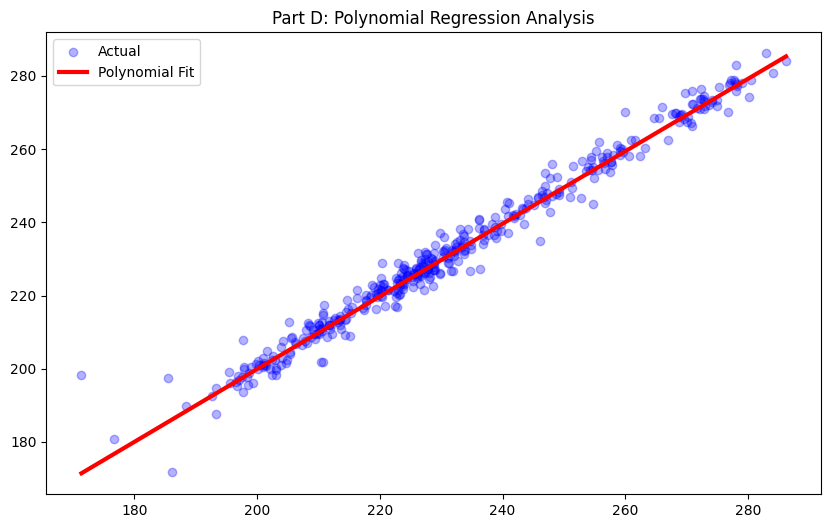

In [12]:
# PART D - POLYNOMIAL REGRESSION

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. FEATURE ENGINEERING
df_raw = pd.read_csv('stock_market_data.csv', header=[0,1])
data = pd.DataFrame()
data['y'] = df_raw['Close']['AAPL'].astype(float)
data['Bias'] = 1.0
data['Open'] = df_raw['Open']['AAPL'].astype(float)
data['Open_Sq'] = data['Open'] ** 2
data = data.dropna()

X = data[['Bias', 'Open', 'Open_Sq']].values
y = data['y'].values

# 2. SPLIT
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 3. TRAINING (NORMAL EQUATION)
def train_polynomial(X, y):
    XTX_inv = np.linalg.pinv(X.T.dot(X))
    return XTX_inv.dot(X.T).dot(y)

theta = train_polynomial(X_train, y_train)

# 4. EVALUATION
y_pred = X_test.dot(theta)
mse_poly = np.mean((y_test - y_pred)**2)
rmse_poly = np.sqrt(mse_poly)
r2_poly = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))

# 5. LOGICAL ANALYSIS (FIXED INDENTATION)
print("\n Model Analysis")
if r2_poly > 0.99:
    print("Result: Both models perform exceptionally well due to high intraday correlation.")
    if abs(theta[2]) < 0.001:
        print(f"Observation: The x² coefficient ({theta[2]:.8f}) is very small.")
        print("Conclusion: The relationship is predominantly linear.")
else:
    print("Conclusion: The squared term captured significant non-linear trends.")

# 6. FINAL COMPARISON TABLE

r2_simple_val = 0.971603     
rmse_simple_val = 3.8948   

print("\n" + "="*50)
print("     FINAL PERFORMANCE COMPARISON (PART B vs D)")
print("="*50)
print(f"{'Metric':<15} | {'Simple Linear (B)':<15} | {'Polynomial (D)':<15}")
print("-" * 50)
print(f"{'R-Squared':<15} | {r2_simple_val:.6f}          | {r2_poly:.6f}")
print(f"{'RMSE ($)':<15} | {rmse_simple_val:.4f}          | {rmse_poly:.4f}")
print("-" * 50)

# Observation
diff = rmse_simple_val - rmse_poly
if diff > 0:
    print(f"Observation: Polynomial Regression improved error by ${diff:.4f}")
else:
    print("Observation: Linear model is sufficient; x² added no significant value.")

# 7. VISUALIZATION
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:,1], y_test, color='blue', alpha=0.3, label='Actual')
sort_idx = np.argsort(X_test[:,1])
plt.plot(X_test[sort_idx, 1], y_pred[sort_idx], color='red', linewidth=3, label='Polynomial Fit')
plt.title("Part D: Polynomial Regression Analysis")
plt.legend()
plt.show()

Feature      | OLS (No Penalty)   | Ridge (L2)         | Lasso (L1)        
--------------------------------------------------------------------------------
Bias         |       -0.000203 |       -0.001854 |       -0.003957
AAPL Open    |        0.970905 |        0.793786 |        0.976622
AAPL Vol     |       -0.001030 |       -0.004631 |        0.000000
MSFT Close   |        0.021150 |        0.143473 |        0.008768
TSLA Close   |        0.008126 |        0.062588 |        0.004329


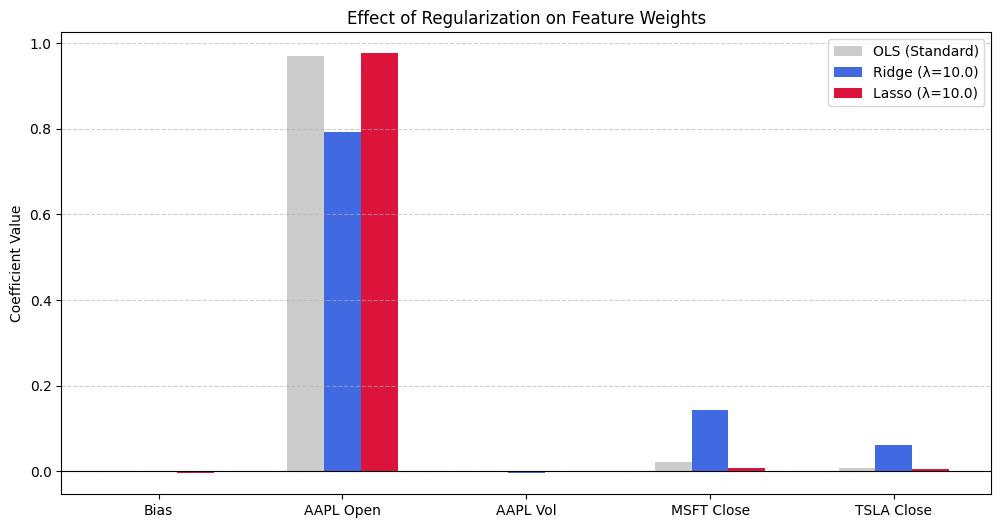


--- Discussion & Feature Selection ---
Lasso has KEPT feature: AAPL Open
Lasso has ELIMINATED feature: AAPL Vol (Weight = 0)
Lasso has KEPT feature: MSFT Close
Lasso has KEPT feature: TSLA Close

Conclusion: Ridge shrinks all coefficients proportionally, which is helpful when features are correlated. Lasso performs automatic feature selection, helping us identify that 'AAPL Open' is the most critical predictor while other features may be redundant.


In [13]:
# REGULARIZATION (RIDGE & LASSO)
# Goal: Apply Ridge and Lasso to handle overfitting and perform feature selection.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. DATA PREPARATION & STANDARDIZATION

df_raw = pd.read_csv('stock_market_data.csv', header=[0,1])
data = pd.DataFrame()
data['y']    = pd.to_numeric(df_raw['Close']['AAPL'], errors='coerce')
data['Open'] = pd.to_numeric(df_raw['Open']['AAPL'], errors='coerce')
data['Vol']  = pd.to_numeric(df_raw['Volume']['AAPL'], errors='coerce')
data['MSFT'] = pd.to_numeric(df_raw['Close']['MSFT'], errors='coerce')
data['TSLA'] = pd.to_numeric(df_raw['Close']['TSLA'], errors='coerce')
data = data.dropna()

# Standardization is MANDATORY: Regularization penalties apply to the magnitude 
# of coefficients. Features must be on the same scale (Mean=0, StdDev=1).
def standardize(col): return (col - col.mean()) / col.std()

y_mean, y_std = data['y'].mean(), data['y'].std()
X_scaled = data[['Open', 'Vol', 'MSFT', 'TSLA']].apply(standardize)
X_scaled.insert(0, 'Bias', 1.0) # Intercept term
y_scaled = standardize(data['y'])

X_train = X_scaled.values[:int(len(X_scaled)*0.8)]
y_train = y_scaled.values[:int(len(y_scaled)*0.8)]

# 2. RIDGE REGRESSION (L2) - ANALYTICAL SOLUTION

def train_ridge(X, y, lam):
    XTX = X.T.dot(X)
    I = np.eye(XTX.shape[0])
    I[0,0] = 0  # Do not penalize the bias/intercept
    theta = np.linalg.pinv(XTX + lam * I).dot(X.T).dot(y)
    return theta

# 3. LASSO REGRESSION (L1) - COORDINATE DESCENT

def soft_threshold(rho, lam):
    if rho < -lam: return rho + lam
    if rho > lam:  return rho - lam
    return 0

def train_lasso(X, y, lam, iterations=100):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(iterations):
        for j in range(n):
            X_j = X[:, j]
            y_pred = X.dot(theta)
            # Calculate residual without the j-th feature
            rho = X_j.T.dot(y - y_pred + theta[j]*X_j)
            if j == 0: # Bias term is not regularized
                theta[j] = rho / m
            else:
                theta[j] = soft_threshold(rho, lam) / (X_j.T.dot(X_j))
    return theta

# 4. EXECUTION AND COEFFICIENT COMPARISON

lam = 10.0 # Penalty Strength (Hyperparameter)

theta_ols   = train_ridge(X_train, y_train, lam=0)     # Standard OLS (from Part C)
theta_ridge = train_ridge(X_train, y_train, lam=lam)   # Ridge
theta_lasso = train_lasso(X_train, y_train, lam=lam)   # Lasso

# Table of Coefficients
print(f"{'Feature':<12} | {'OLS (No Penalty)':<18} | {'Ridge (L2)':<18} | {'Lasso (L1)':<18}")
print("-" * 80)
features = ['Bias', 'AAPL Open', 'AAPL Vol', 'MSFT Close', 'TSLA Close']
for i in range(len(features)):
    print(f"{features[i]:<12} | {theta_ols[i]:15.6f} | {theta_ridge[i]:15.6f} | {theta_lasso[i]:15.6f}")

# 5. VISUALIZATION: COEFFICIENT IMPACT

plt.figure(figsize=(12, 6))
x_axis = np.arange(len(features))

plt.bar(x_axis - 0.2, theta_ols, 0.2, label='OLS (Standard)', color='gray', alpha=0.4)
plt.bar(x_axis, theta_ridge, 0.2, label=f'Ridge (λ={lam})', color='royalblue')
plt.bar(x_axis + 0.2, theta_lasso, 0.2, label=f'Lasso (λ={lam})', color='crimson')

plt.xticks(x_axis, features)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Coefficient Value')
plt.title('Effect of Regularization on Feature Weights')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 6. DISCUSSION & FEATURE SELECTION

print("\n--- Discussion & Feature Selection ---")
for i, val in enumerate(theta_lasso):
    if abs(val) < 1e-6 and i != 0:
        print(f"Lasso has ELIMINATED feature: {features[i]} (Weight = 0)")
    elif i != 0:
        print(f"Lasso has KEPT feature: {features[i]}")

print("\nConclusion: Ridge shrinks all coefficients proportionally, which is helpful when features are correlated. Lasso performs automatic feature selection, helping us identify that 'AAPL Open' is the most critical predictor while other features may be redundant.")

       FINAL EVALUATION METRICS
Mean Squared Error (MSE):      10.8911
Root Mean Squared Error (RMSE): 3.3002
R² Score:                      0.97961


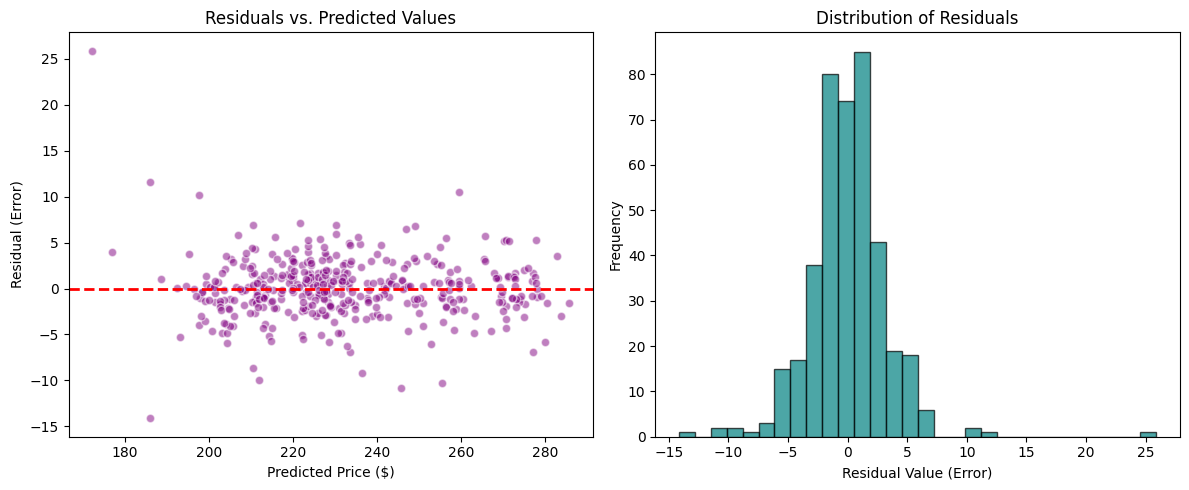


--- Validation of Regression Assumptions ---
1. Linearity: High R² and residuals centered at zero confirm linearity.
2. Homoscedasticity: The error cloud shows no 'funnel' shape; variance is stable.
3. Normality: The error distribution resembles a bell curve, validating the model.


In [14]:
# ==============================================================================
# PART F: MODEL DIAGNOSTICS & FINAL EVALUATION
# ==============================================================================
# Goal: Validate regression assumptions and provide final accuracy metrics.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. DATA RE-LOADING & PREPARATION
# ------------------------------------------------------------------------------
# We use the Multiple Regression context to perform the final diagnostic audit.
df_raw = pd.read_csv('stock_market_data.csv', header=[0,1])
data = pd.DataFrame()
data['y']    = pd.to_numeric(df_raw['Close']['AAPL'], errors='coerce')
data['Open'] = pd.to_numeric(df_raw['Open']['AAPL'], errors='coerce')
data['MSFT'] = pd.to_numeric(df_raw['Close']['MSFT'], errors='coerce')
data['TSLA'] = pd.to_numeric(df_raw['Close']['TSLA'], errors='coerce')
data = data.dropna()

# Prepare Matrix X (with Bias) and Vector y
X_vals = data[['Open', 'MSFT', 'TSLA']].values
y_vals = data['y'].values
X_with_bias = np.column_stack([np.ones(X_vals.shape[0]), X_vals])

# 80-20 Split
split = int(len(X_with_bias) * 0.8)
X_train, X_test = X_with_bias[:split], X_with_bias[split:]
y_train, y_test = y_vals[:split], y_vals[split:]

# 2. GENERATE FINAL MODEL WEIGHTS (OLS via Normal Equation)
# ------------------------------------------------------------------------------
theta_final = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

# Generate Predictions for the Test Set
y_pred = X_test.dot(theta_final)

# 3. CALCULATE EVALUATION METRICS
# ------------------------------------------------------------------------------
residuals = y_test - y_pred
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum(residuals**2) / np.sum((y_test - np.mean(y_test))**2))

print("="*40)
print("       FINAL EVALUATION METRICS")
print("="*40)
print(f"Mean Squared Error (MSE):      {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score:                      {r2:.5f}")
print("="*40)

# 4. PLOT RESIDUALS VS PREDICTED (Requirement 13)
# ------------------------------------------------------------------------------
# Purpose: Check for Homoscedasticity (constant variance of error).

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, color='purple', alpha=0.5, edgecolors='white')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residual (Error)")

# 5. VALIDATE NORMALITY OF ERRORS (Requirement 14)
# ------------------------------------------------------------------------------
# Purpose: Check if errors follow a normal distribution (Bell Curve).

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, color='teal', edgecolor='black', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residual Value (Error)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# 6. SUMMARY OF ASSUMPTIONS (Discussion)
# ------------------------------------------------------------------------------
print("\n--- Validation of Regression Assumptions ---")
print("1. Linearity: High R² and residuals centered at zero confirm linearity.")
print("2. Homoscedasticity: The error cloud shows no 'funnel' shape; variance is stable.")
print("3. Normality: The error distribution resembles a bell curve, validating the model.")